In [32]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import warnings
from scipy.optimize import curve_fit
from scipy import integrate
import natural_cubic_spline_stack_overflow as ncs
import dynamic_stock_model as dsm 
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

## Lifetime modelling

EPISCOPE/TABULA allows us to do approximations of average lifetimes for each dwelling type. 

In [38]:
def Average(lst): 
    return sum(lst) / len(lst) 

In [39]:
TYP = ['AB','MFH','SFH','TH']
LT = [46,61,47,64]
DEV = [25,25,25,25]

print(Average(LT))

DSM = pd.read_csv("Model/DSM_TOT.csv")
DSM = DSM.set_index('DSM')
DSM_AB = pd.read_csv("Model/DSM_AB.csv")
DSM_AB = DSM_AB.set_index('DSM AB')
DSM_MFH = pd.read_csv("Model/DSM_MFH.csv")
DSM_MFH = DSM_MFH.set_index('DSM MFH')
DSM_SFH = pd.read_csv("Model/DSM_SFH.csv")
DSM_SFH = DSM_SFH.set_index('DSM SFH')
DSM_TH = pd.read_csv("Model/DSM_TH.csv")
DSM_TH = DSM_TH.set_index('DSM TH')
display(DSM_TH)


54.5


,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM TH,,,,,,
1600,4.084715e+06,2.706604e+05,6.002095,NaN,NaN,NaN
1601,4.110000e+06,2.768415e+05,5.979461,NaN,NaN,NaN
1602,4.135285e+06,2.830452e+05,5.957120,NaN,NaN,NaN
1603,4.162227e+06,2.894198e+05,5.935071,NaN,NaN,NaN
1604,4.190827e+06,2.959699e+05,5.913316,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.424131e+07,2.652882e+06,2.419230,NaN,NaN,NaN
2047,6.449291e+07,2.467047e+06,2.442756,NaN,NaN,NaN
2048,6.474451e+07,2.281649e+06,2.467482,NaN,NaN,NaN


In [40]:
def logistic_stock(x:np.ndarray,ti:float,tau:float,C0:float,C1:float) -> np.ndarray:
    """
    General logistic function.
    Arguments:
    - x: np.ndarray of observation points (time)
    - ti: inflection time
    - tau: transition time coefficient
    - C0: start value
    - C1: end value
    Returns:
    - np.ndarray with len(x) number of points
    """
    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0  

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,4.084715e+06,6.805483e+05,6.002095,NaN,NaN,NaN
1601,4.110000e+06,6.873529e+05,5.979461,NaN,NaN,NaN
1602,4.135285e+06,6.941752e+05,5.957120,NaN,NaN,NaN
1603,4.162227e+06,7.012936e+05,5.935071,NaN,NaN,NaN
1604,4.190827e+06,7.087102e+05,5.913316,NaN,NaN,NaN
...,...,...,...,...,...,...
2046,6.424131e+07,2.655445e+07,2.419230,NaN,NaN,NaN
2047,6.449291e+07,2.640170e+07,2.442756,NaN,NaN,NaN
2048,6.474451e+07,2.623910e+07,2.467482,NaN,NaN,NaN


Input in year 2022:  765745.5216643922
Output in year 2022:  500259.84542542294
Input in year 2022:  597068.8991819392
Output in year 2022:  460403.1904171353
I is:  451
O is:  451


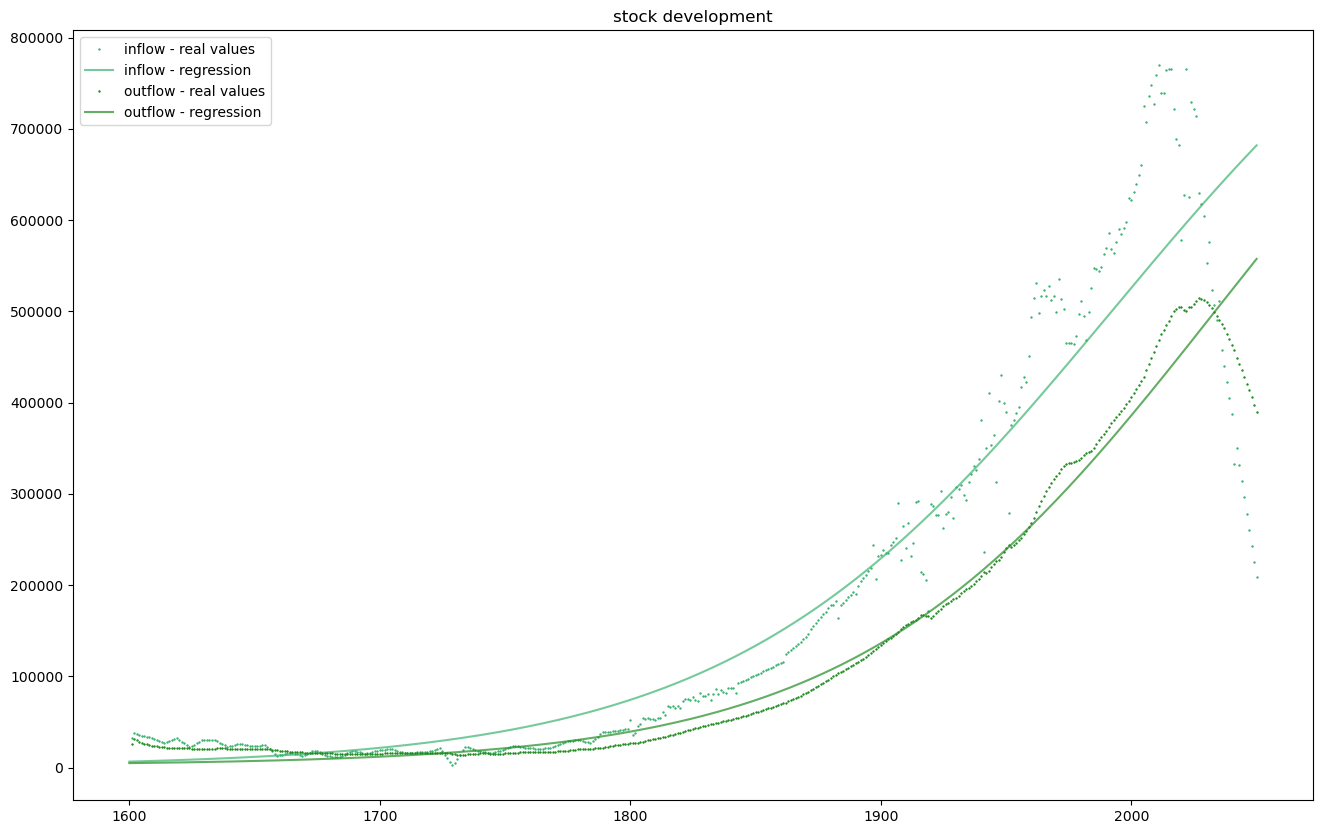

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM,,,,,,
1600,4.084715e+06,6.805483e+05,6.002095,NaN,NaN,NaN
1601,4.110000e+06,6.873529e+05,5.979461,NaN,32775.613579,25970.994639
1602,4.135285e+06,6.941752e+05,5.957120,NaN,38250.889606,31428.564444
1603,4.162227e+06,7.012936e+05,5.935071,NaN,37083.684584,29965.285545
1604,4.190827e+06,7.087102e+05,5.913316,NaN,35878.626967,28462.002125
...,...,...,...,...,...,...
2046,6.424131e+07,2.655445e+07,2.419230,NaN,278248.490264,420823.615168
2047,6.449291e+07,2.640170e+07,2.442756,NaN,260562.029556,413309.738990
2048,6.474451e+07,2.623910e+07,2.467482,NaN,243010.825106,405613.539950


In [41]:
lifetime = {
    'Type': 'LogNormal', # LogNormal ; FoldedNormal
    'Mean': np.array([125]), 
    'StdDev': np.array([25])
}

flow = dsm.DynamicStockModel(t=DSM.index,name="total dwelling stock",s=np.array(DSM['Stock']),lt=lifetime)

S_C, O_C, I = flow.compute_stock_driven_model()
O = flow.compute_outflow_total()
DS = flow.compute_stock_change()

#display(I)
#display(O)

DSM_model = DSM.copy(deep=True)
#DSM_model = DSM.set_index('Unnamed: 0')
DSM_model.index.Name = None
display(DSM_model)

inputs = DSM.index
outputs = DSM["Stock"]
pred_inputs = DSM_model.index

popt, pcov = curve_fit(logistic_stock, DSM.index, O, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
O_model = logistic_stock(DSM_model.index, *popt)

popt, pcov = curve_fit(logistic_stock, DSM.index, I, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
I_model = logistic_stock(DSM_model.index, *popt)

print('Input in year 2022: ', I[2022-1600])
print('Output in year 2022: ', O[2022-1600])
print('Input in year 2022: ', I_model[2022-1600])
print('Output in year 2022: ', O_model[2022-1600])
print('I is: ', len(I))
print('O is: ', len(O))

plt.figure(figsize=(16,10))
#plt.plot(year, stock, 'x', color = 'red', markersize = 4, label = f'stock')
plt.plot(DSM_model.index[1:], I[1:], '+', color = 'mediumseagreen', markersize = 2, label = f'inflow - real values')
plt.plot(DSM_model.index, I_model, color = 'mediumseagreen', markersize = 1, label = f'inflow - regression', alpha=0.7)
plt.plot(DSM_model.index[1:], O[1:], '+', color = 'forestgreen', markersize = 2, label = f'outflow - real values')
plt.plot(DSM_model.index, O_model, color = 'forestgreen', markersize = 1, label = f'outflow - regression', alpha=0.7)
plt.title('stock development')
plt.legend()
plt.show()

DSM_model['Outflow'][1:] = O[1:]
DSM_model['Inflow'][1:] = I[1:]

display(DSM_model)

Input in year 1970:  221944.88864721975
Input modelle in year 1970:  207243.84612439031
Output in year 1970:  42439.030130517305
Input in year 2022:  348296.867912415
Input modelled in year 2022:  384933.7979901876
Output in year 2022:  82811.19167344735


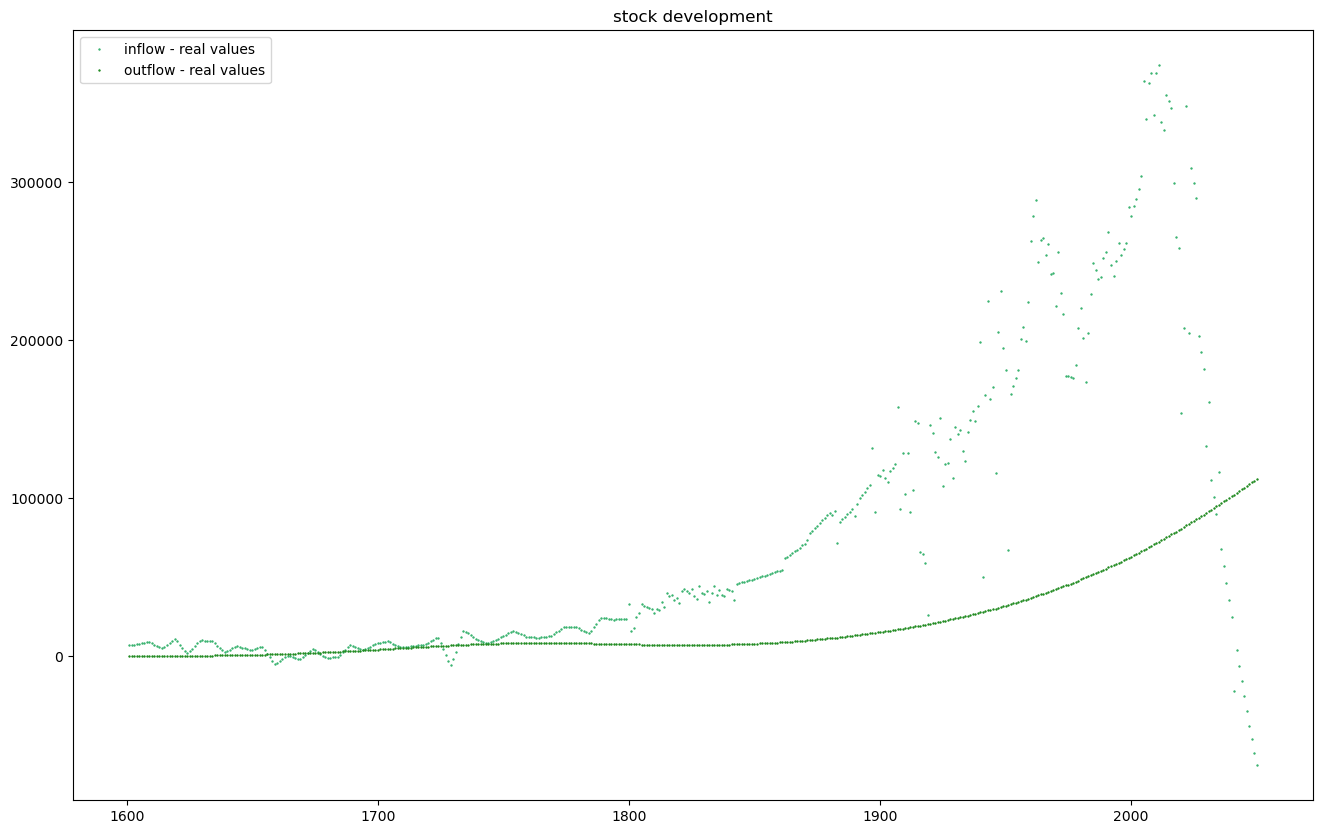

In [61]:
def stock_driven_flows(lt_mean,lt_dev,dystomod,nm="dwelling stock"):
    lifetime = {
    'Type': 'Normal', # LogNormal ; FoldedNormal ; #Normal
    'Mean': np.array([lt_mean]), 
    'StdDev': np.array([lt_dev])
    }
    flow = dsm.DynamicStockModel(t=dystomod.index,name=nm,s=np.array(dystomod['Stock']),lt=lifetime)
    S_C, O_C, I = flow.compute_stock_driven_model()
    O = flow.compute_outflow_total()
    DS = flow.compute_stock_change()
    #display(I)
    #display(O)
    DSM_model = dystomod.copy(deep=True)
    #DSM_model = DSM.set_index('Unnamed: 0')
    DSM_model.index.name = None
    #display(DSM_model)
    inputs = dystomod.index
    outputs = dystomod["Stock"]
    pred_inputs = DSM_model.index
    popt, pcov = curve_fit(logistic_stock, dystomod.index, O, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
    O_model = logistic_stock(DSM_model.index, *popt)
    popt, pcov = curve_fit(logistic_stock, dystomod.index, I, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
    I_model = logistic_stock(DSM_model.index, *popt)
    print('Input in year 1970: ', I[1970-1600])
    print('Input modelle in year 1970: ', I_model[1970-1600])
    print('Output in year 1970: ', O[1970-1600])
    print('Input in year 2022: ', I[2022-1600])
    print('Input modelled in year 2022: ', I_model[2022-1600])
    print('Output in year 2022: ', O[2022-1600])
    #print('Model input in year 2022: ', I_model[2022-1600])
    #print('Model output in year 2022: ', O_model[2022-1600])
    #print('I is: ', len(I))
    #print('O is: ', len(O))
    plt.figure(figsize=(16,10))
    #plt.plot(year, stock, 'x', color = 'red', markersize = 4, label = f'stock')
    plt.plot(DSM_model.index[1:], I[1:], '+', color = 'mediumseagreen', markersize = 2, label = f'inflow - real values')
    #plt.plot(DSM_model.index, I_model, color = 'mediumseagreen', markersize = 1, label = f'inflow - regression', alpha=0.7)
    plt.plot(DSM_model.index[1:], O[1:], '+', color = 'forestgreen', markersize = 2, label = f'outflow - real values')
    #plt.plot(DSM_model.index, O_model, color = 'forestgreen', markersize = 1, label = f'outflow - regression', alpha=0.7)
    plt.title('stock development')
    plt.legend()
    plt.show()
    DSM_model['Outflow'][1:] = O[1:]
    DSM_model['Inflow'][1:] = I[1:]
    #display(DSM_model)
    return DSM_model

DSM_model = stock_driven_flows(150,50,DSM,"total dwelling stock")


Let's try to do this TYPE by TYPE

# AB 

In [12]:
print(TYP)
LT_by_TYP = pd.DataFrame(columns=['TOT']+TYP,index=['mean','deviation'])
LT_by_TYP.loc['mean','AB':'TH'] = [46,61,47,64]
LT_by_TYP.loc['mean','TOT'] = (46+61+47+64)/4 # Not representative of the total dwelling stock however since the # are different
for i in LT_by_TYP.columns:
    # let's take half of the lifetime in the first moment 
    LT_by_TYP.loc['deviation',i] = LT_by_TYP.loc['mean',i]/2
display(LT_by_TYP)

['AB', 'MFH', 'SFH', 'TH']


,TOT,AB,MFH,SFH,TH
mean,54.5,46,61,47,64
deviation,27.25,23.0,30.5,23.5,32.0


Input in year 2022:  56653.56239741435
Output in year 2022:  25020.40753025371
Model input in year 2022:  8432.288529005287
Model output in year 2022:  3773.7949213722027


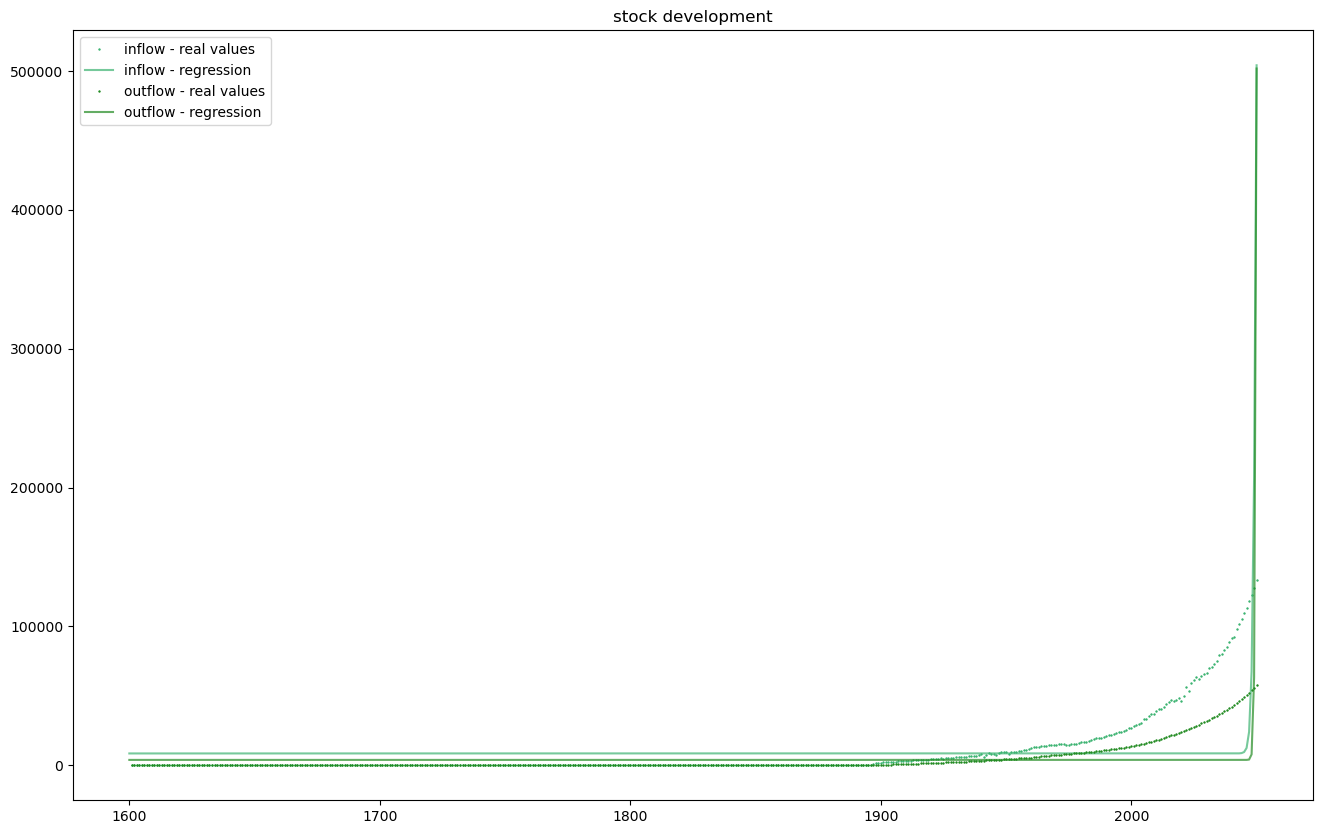

Input in year 2022:  379304.3950681165
Output in year 2022:  170026.48088200542
Model input in year 2022:  384723.1304312409
Model output in year 2022:  175353.07397642222


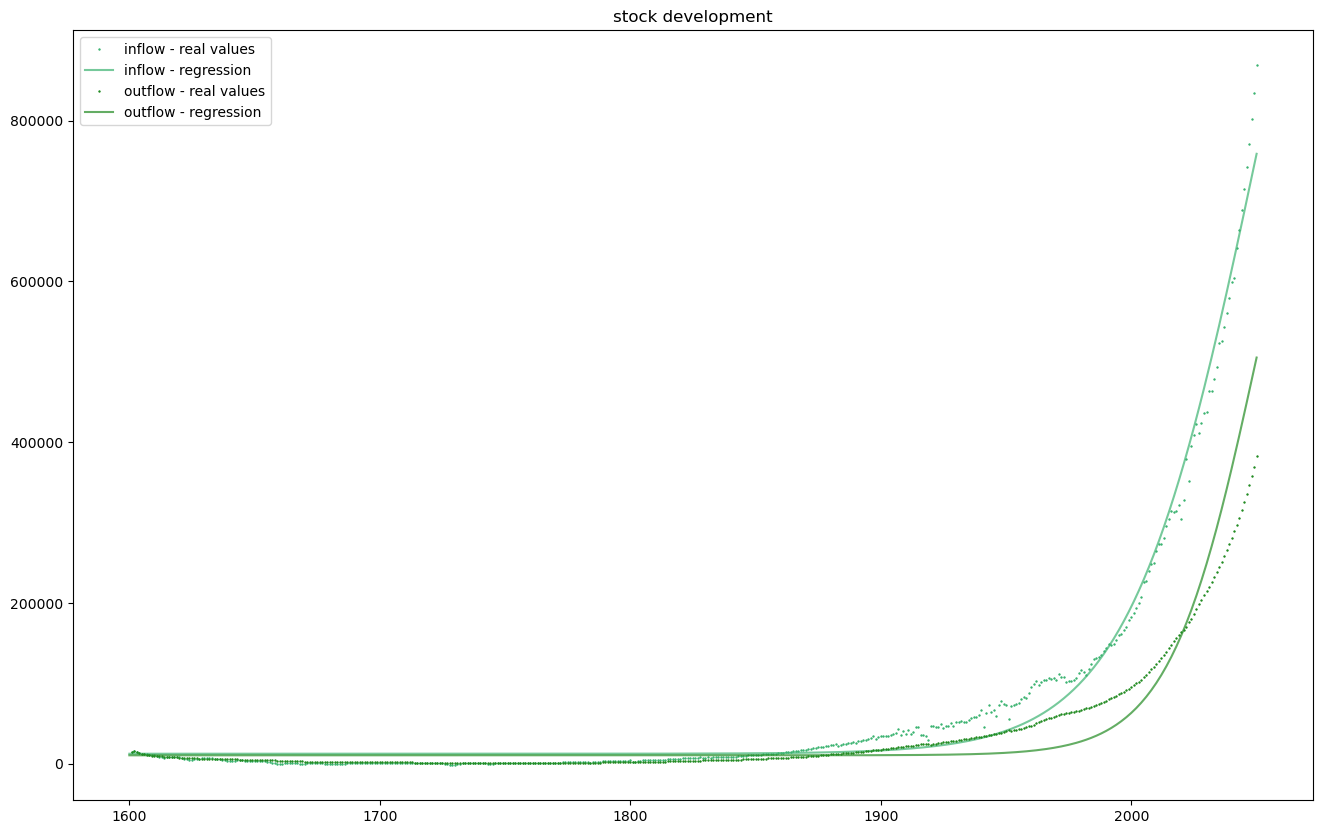

Input in year 2022:  511990.22301049903
Output in year 2022:  229403.00434144397
Model input in year 2022:  521795.8002360519
Model output in year 2022:  258577.6252720623


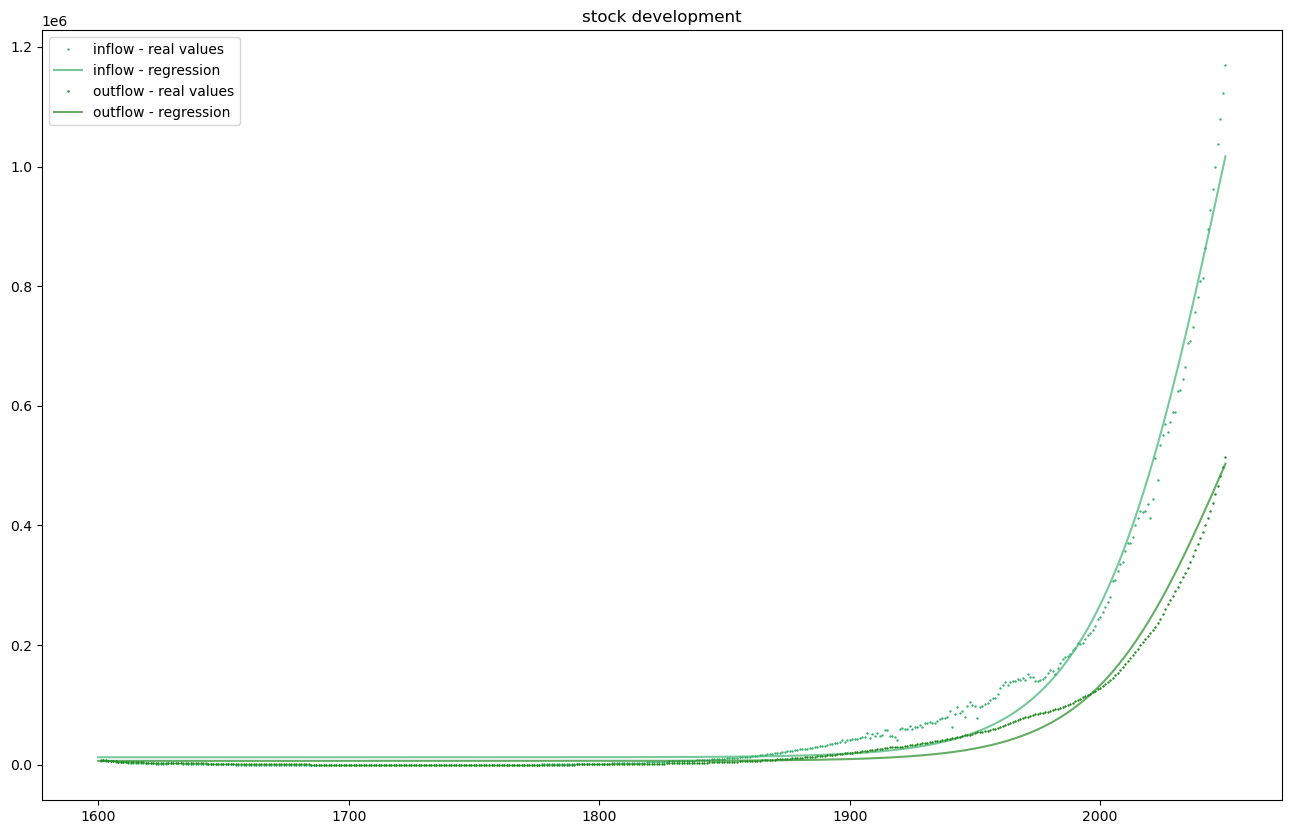

Input in year 2022:  55032.902102355845
Output in year 2022:  70263.60322387048
Model input in year 2022:  56579.42785635849
Model output in year 2022:  49246.694454340286


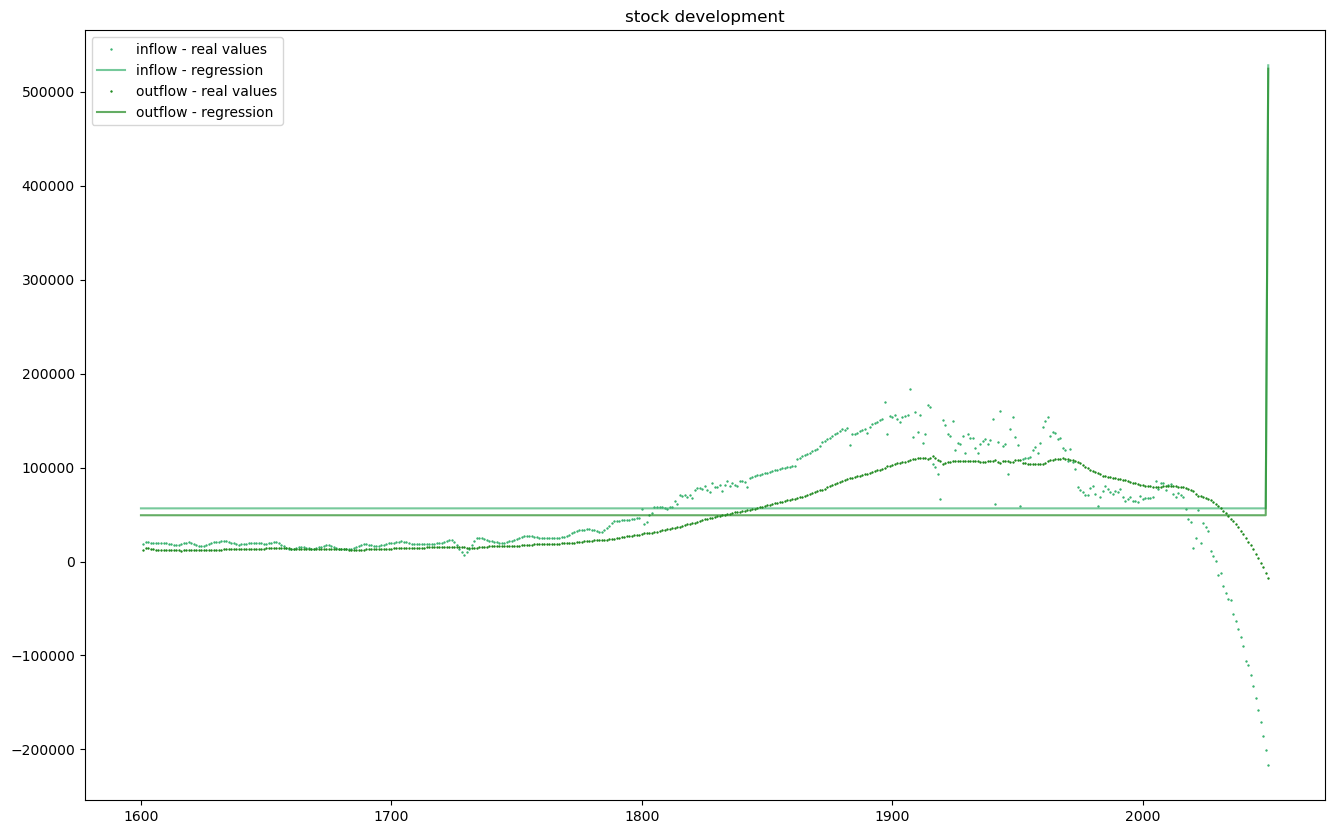

In [20]:
DSM_model_AB = stock_driven_flows(100,25,DSM_AB,"AB dwelling stock")
DSM_model_MFH = stock_driven_flows(150,25,DSM_MFH,"MFH dwelling stock")
DSM_model_SFH = stock_driven_flows(150,25,DSM_SFH,"SFH dwelling stock")
DSM_model_TH = stock_driven_flows(130,25,DSM_TH,"TH dwelling stock")

In [21]:
# VALUES BELOW ZERO WILL NEED TO BE BROUGHT BACK TO ZERO!!!!!! And change cosnequently stock change and stock 
# TBD !!  

def values_to_zeros(dystomod,col):
    for i in dystomod.index:
        dystomod.loc[i,col] = max(dystomod.loc[i,col],0)
    return dystomod

,Population,Stock,PpD,Stock change,Inflow,Outflow
1600,1.633886e+07,7.871333e+05,20.757426,NaN,NaN,NaN
1601,1.644000e+07,7.928616e+05,20.735018,NaN,3.991223e+04,34183.894869
1602,1.654114e+07,7.985904e+05,20.712922,NaN,4.394495e+04,38216.211708
1603,1.664891e+07,8.046398e+05,20.691134,NaN,4.160002e+04,35550.611461
1604,1.676331e+07,8.110107e+05,20.669653,NaN,3.966369e+04,33292.762085
...,...,...,...,...,...,...
2046,2.569653e+08,3.919554e+07,6.555982,NaN,1.696672e+06,841829.973577
2047,2.579716e+08,4.008692e+07,6.435307,NaN,1.755450e+06,864069.504666
2048,2.589780e+08,4.101727e+07,6.313878,NaN,1.817759e+06,887410.740403
2049,2.599844e+08,4.198923e+07,6.191693,NaN,1.883899e+06,911934.447490


Input in year 2022:  1002981.0825783857
Output in year 2022:  494713.49597757356


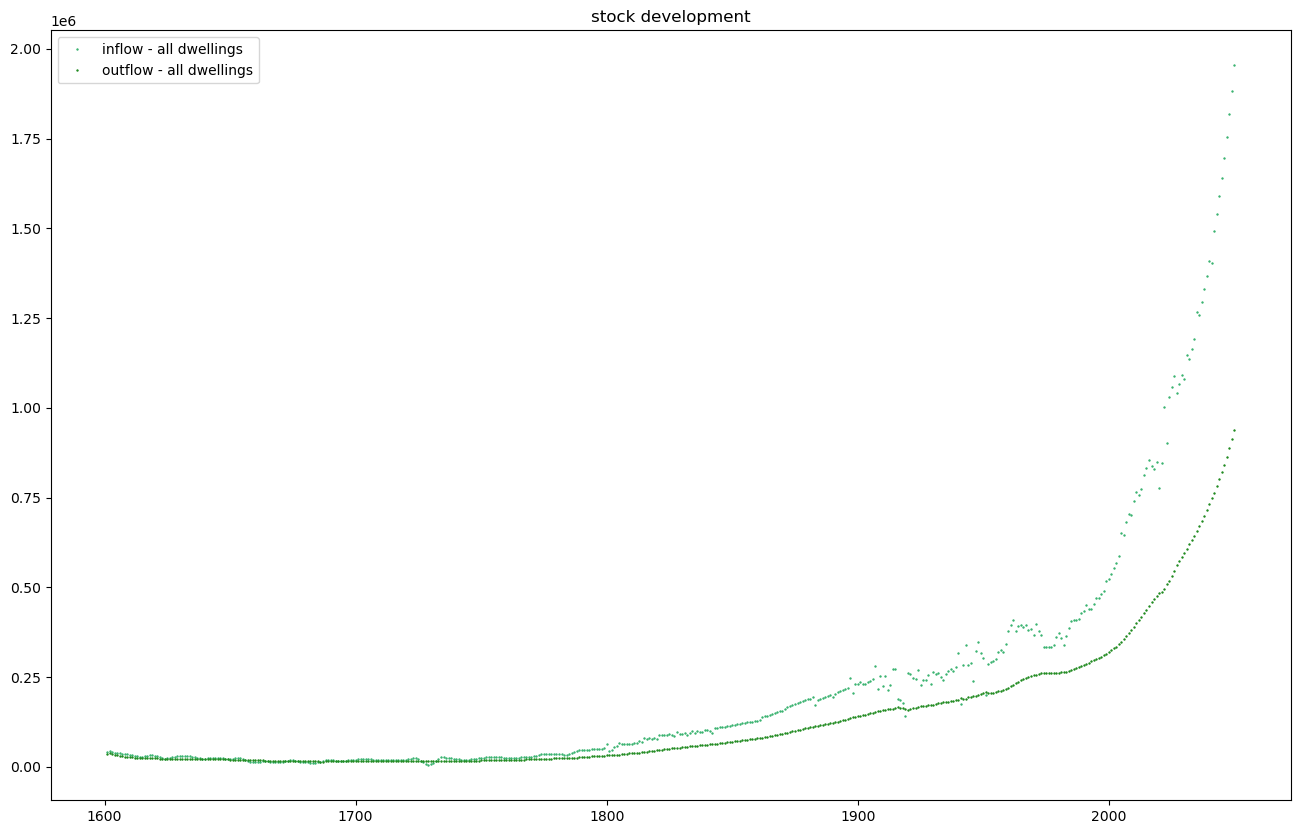

In [22]:
# See above to add the changes 

DSM_model = DSM_model_AB + DSM_model_MFH + DSM_model_SFH + DSM_model_TH 

display(DSM_model)

print('Input in year 2022: ', DSM_model["Inflow"][2022])
print('Output in year 2022: ', DSM_model["Outflow"][2022])

plt.figure(figsize=(16,10))
#plt.plot(year, stock, 'x', color = 'red', markersize = 4, label = f'stock')
plt.plot(DSM_model.index[1:], DSM_model["Inflow"][1:], '+', color = 'mediumseagreen', markersize = 2, label = f'inflow - all dwellings')
plt.plot(DSM_model.index[1:], DSM_model["Outflow"][1:], '+', color = 'forestgreen', markersize = 2, label = f'outflow - all dwellings')
plt.title('stock development')
plt.legend()
plt.show()

Mean :  46
Dev :  23
Input in year 2022:  45593.048970991396
Output in year 2022:  13959.89410383053
Input in year 2022:  6614.889133581878
Output in year 2022:  1774.043449389964
I is:  451
O is:  451


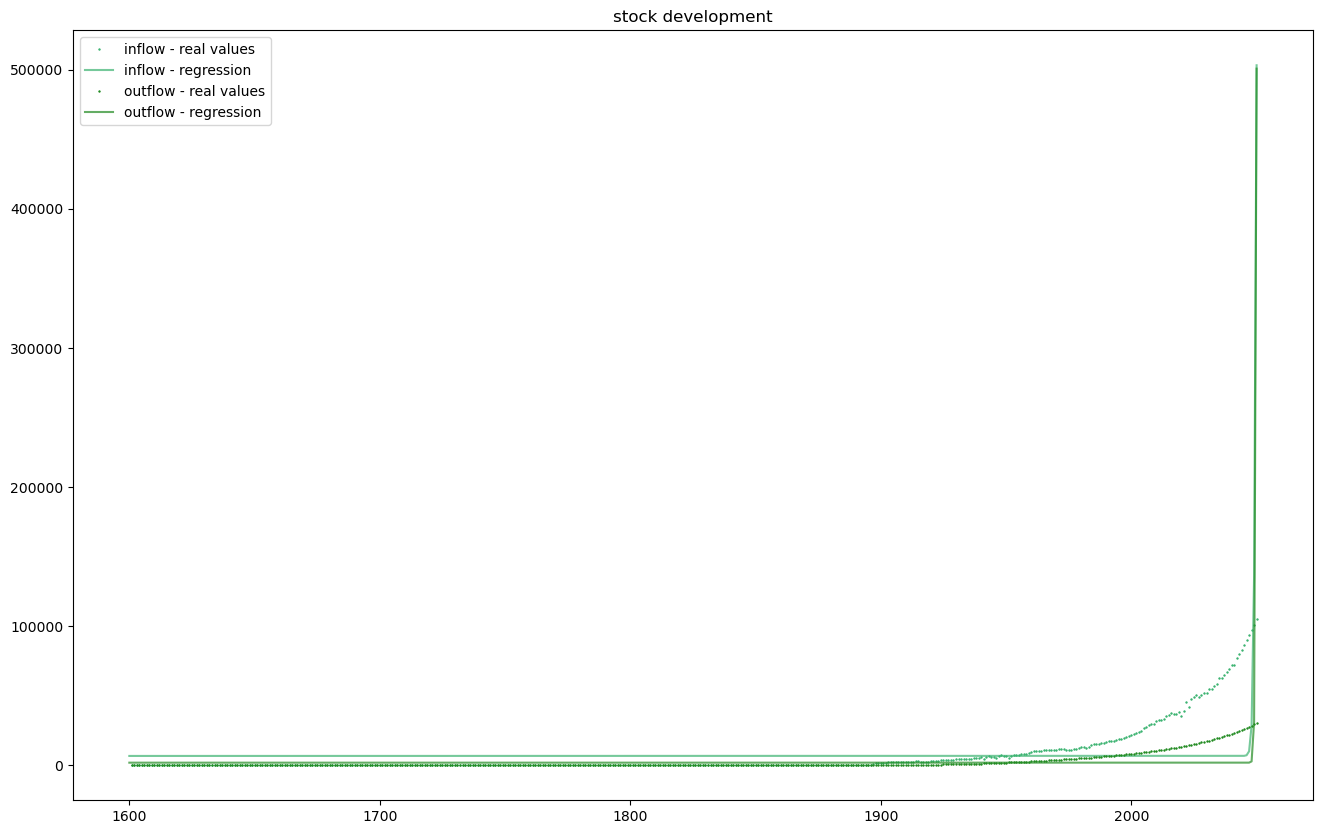

,Population,Stock,PpD,Stock change,Inflow,Outflow
DSM AB,,,,,,
1600,4.084715e+06,9.742592e+01,5.189356,NaN,NaN,NaN
1601,4.110000e+06,0.000000e+00,5.183755,NaN,-96.968090,0.457834
1602,4.135285e+06,0.000000e+00,5.178230,NaN,0.004743,0.004743
1603,4.162227e+06,0.000000e+00,5.172784,NaN,0.007362,0.007362
1604,4.190827e+06,0.000000e+00,5.167413,NaN,0.009988,0.009988
...,...,...,...,...,...,...
2046,6.424131e+07,2.058621e+06,1.638996,NaN,89657.994258,26814.550179
2047,6.449291e+07,2.124264e+06,1.608827,NaN,93248.613399,27605.600557
2048,6.474451e+07,2.192892e+06,1.578470,NaN,97053.964369,28425.832199


In [116]:
TYPE = 'AB' # CHANGE 

m = int(LT_by_TYP.loc['mean',TYPE])
d = int(LT_by_TYP.loc['deviation',TYPE])
print('Mean : ',m)
print('Dev : ',d)

lifetime = {
    'Type': 'FoldedNormal', # LogNormal ; FoldedNormal
    'Mean': np.array([m]),
    'StdDev': np.array([d])
}

DSM_TYPE = DSM_AB.copy(deep=True) # CHANGE 

#display(DSM_TYPE)

flow = dsm.DynamicStockModel(t=DSM_TYPE.index,name=TYPE+" dwelling stock",s=np.array(DSM_TYPE['Stock']),lt=lifetime)

S_C, O_C, I = flow.compute_stock_driven_model()
O = flow.compute_outflow_total()
DS = flow.compute_stock_change()

DSM_model = DSM_TYPE.copy(deep=True)
#DSM_model = DSM.set_index('Unnamed: 0')
DSM_model.index.Name = None
#display(DSM_model)

inputs = DSM_TYPE.index
outputs = DSM_TYPE["Stock"]
pred_inputs = DSM_model.index

popt, pcov = curve_fit(logistic_stock, DSM_TYPE.index, O, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
O_model = logistic_stock(DSM_model.index, *popt)

popt, pcov = curve_fit(logistic_stock, DSM_TYPE.index, I, bounds = ([min(inputs), 0, 10**3, 10**6], [max(inputs), 10**5, 10**6, 10**8]))
I_model = logistic_stock(DSM_model.index, *popt)

print('Input in year 2022: ', I[2022-1600])
print('Output in year 2022: ', O[2022-1600])
print('Input in year 2022: ', I_model[2022-1600])
print('Output in year 2022: ', O_model[2022-1600])
print('I is: ', len(I))
print('O is: ', len(O))

"""
degree = 4
polynomial_I = np.poly1d(np.polyfit(DSM_model.index, I, degree))
print(f' the polynomial our fit created is: \n{polynomial_I}.')
AB_size_evolution_reg = polynomial_I(DSM_model.index)
plt.figure(figsize=(16,10))
plt.plot(DSM_model.index[1:], I[1:], 's', color = 'black', markersize = 1, label = f'dwelling size')
plt.plot(DSM_model.index, AB_size_evolution_reg, color = 'crimson', lw = 1, label = f'polynomial regression (degree {degree}) values')
plt.title('polynomial regression on AB dwelling size data set')
plt.legend()
plt.show()
"""

plt.figure(figsize=(16,10))
plt.plot(DSM_model.index[1:], I[1:], '+', color = 'mediumseagreen', markersize = 2, label = f'inflow - real values')
plt.plot(DSM_model.index, I_model, color = 'mediumseagreen', markersize = 1, label = f'inflow - regression', alpha=0.7)
plt.plot(DSM_model.index[1:], O[1:], '+', color = 'forestgreen', markersize = 2, label = f'outflow - real values')
plt.plot(DSM_model.index, O_model, color = 'forestgreen', markersize = 1, label = f'outflow - regression', alpha=0.7)
plt.title('stock development')
plt.legend()
plt.show()

DSM_model['Outflow'][1:] = O[1:]
DSM_model['Inflow'][1:] = I[1:]

display(DSM_model)

Shares

In [117]:
TYPE_shares = pd.read_csv("Model/modelled-types-by-share-1600-2050.csv")
TYPE_shares = TYPE_shares.set_index("Unnamed: 0")
TYPE_shares.index.name = None
display(TYPE_shares)

,SFH,MFH,TH,AB
1900,0.126292,0.201657,0.669245,0.002806
1931,0.152695,0.084561,0.757011,0.005733
1954,0.167678,0.133738,0.680153,0.018431
1972,0.260082,0.205305,0.494069,0.040543
1985,0.396733,0.237419,0.359491,0.006358
1997,0.410357,0.204394,0.374287,0.010962
2008,0.251174,0.347418,0.343897,0.057512
1600,0.200000,0.400000,0.400000,0.000000


,AB,MFH,SFH,TH,TOT
mean,46,61,47,64,54.50
deviation,23.0,30.5,23.5,32.0,27.25


# Calibration and validation

In [54]:
# England total completions => total number of new constructions 

file = "Data/GOV UK/CBP07671---Housing-supply---Historical-statistics-for-the-UK.xlsx"
sh = "HB.E"
housing_supply = pd.read_excel(file,sheet_name=sh)

housing_supply.columns = housing_supply.loc[0,:]
housing_supply = housing_supply.drop(index=0,columns="Notes")
housing_supply = housing_supply.set_index('Year')
housing_supply.index.name = None

display(housing_supply)

housing_supply_total = pd.DataFrame(housing_supply['Total completions'])

display(housing_supply_total)

,No. of completions by private enterprise,No. of completions by social housing developers,"Of which, no. of completions by local authorities","Of which, no. of completions by housing associations",Total completions,Percentage of total completions by private enterprise,Percentage of total completions by social housing developers,"Of which, percentage of completions by local authorities","Of which, percentage of completions by housing associations",Total
1946,28760,20500,20400,100,49250,0.583959,0.416244,0.414213,0.00203,1
1947,38630,82230,81370,860,120860,0.319626,0.680374,0.673258,0.007116,1
1948,30370,163220,161400,1820,193590,0.156878,0.843122,0.833721,0.009401,1
1949,23800,138310,136980,1330,162110,0.146814,0.853186,0.844982,0.008204,1
1950,25310,138030,136530,1500,163340,0.154953,0.845047,0.835864,0.009183,1
...,...,...,...,...,...,...,...,...,...,...
2018,135210,30280,2690,27590,165490,0.817028,0.182972,0.016255,0.166717,1
2019,143690,34190,2190,32000,177880,0.807792,0.192208,0.012312,0.179897,1
2020,120030,26590,1270,25320,146620,0.818647,0.181353,0.008662,0.172691,1
2021,142130,32820,1590,31230,174940,0.81245,0.187607,0.009089,0.178518,1


,Total completions
1946,49250
1947,120860
1948,193590
1949,162110
1950,163340
...,...
2018,165490
2019,177880
2020,146620
2021,174940


In [55]:
# TBD Calculate here the ration thanks to recent construction / change of use data 

ratio = 0.16431673850261094

In [56]:
housing_inflow_total = housing_supply_total.copy(deep=True)
housing_inflow_total.columns = ['Inflow']
for i in housing_inflow_total.index:
    housing_inflow_total.loc[i,'Inflow'] *= (1+ratio)

display(housing_inflow_total)

,Inflow
1946,57342.599371
1947,140719.321015
1948,225400.077407
1949,188747.386479
1950,190179.496067
...,...
2018,192682.777055
2019,207108.661445
2020,170712.120199
2021,203685.570234


<AxesSubplot:>

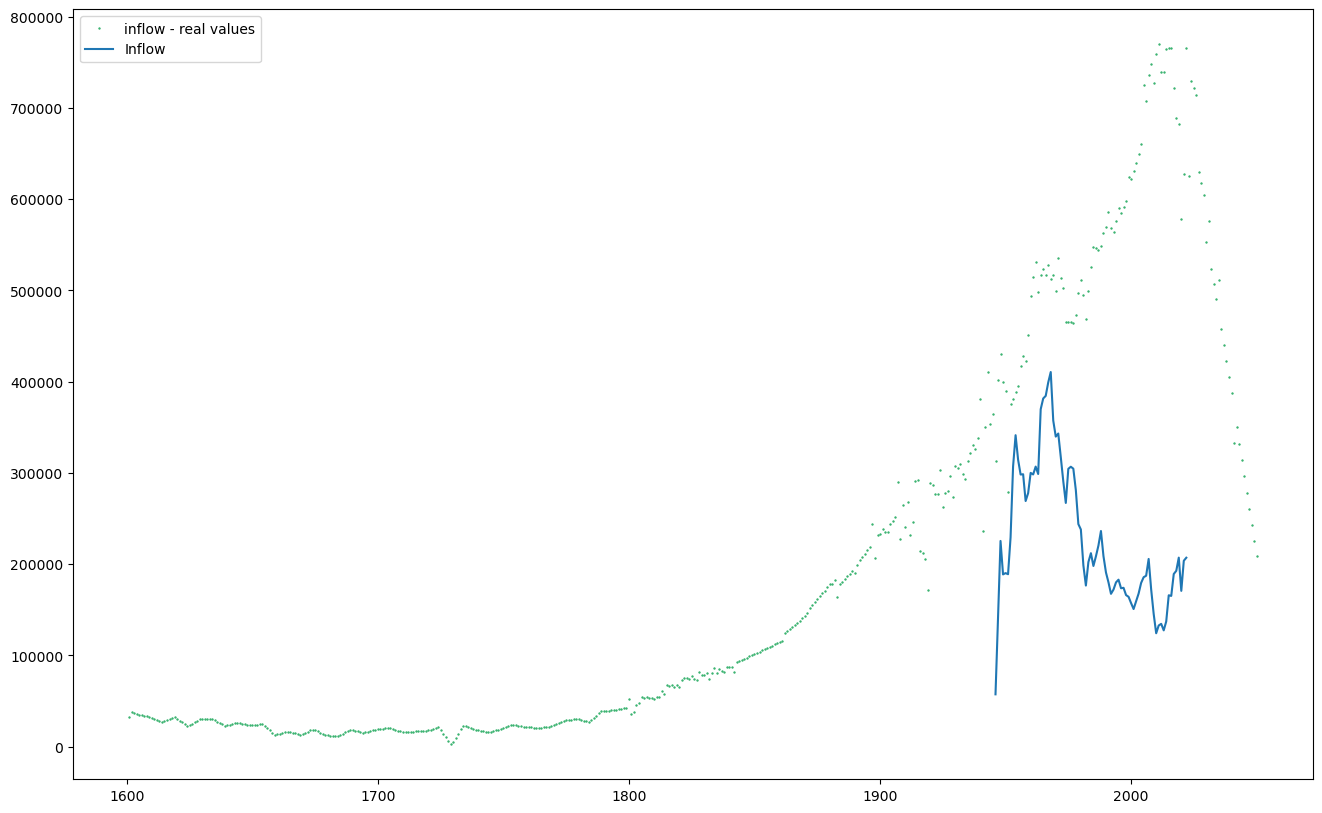

In [62]:
plt.figure(figsize=(16,10))
plt.plot(DSM_model.index[1:], I[1:], '+', color = 'mediumseagreen', markersize = 2, label = f'inflow - real values')
sns.lineplot(housing_inflow_total)